Before we get started, you may choose to run this notebook on LEAP-Pangeo hub or Binder!

<a href="https://leap.2i2c.cloud/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fm2lines%2Fdata-gallery&urlpath=lab%2Ftree%2Fdata-gallery%2Fnotebooks%2FOM4_SE_animation.ipynb&branch=main"><img src="https://custom-icon-badges.demolab.com/badge/LEAP-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:30px;"></a>

<a href="https://mybinder.org/v2/gh/m2lines/data-gallery/main?labpath=notebooks%2FOM4_SE_animation.ipynb"><img src="https://custom-icon-badges.demolab.com/badge/Binder-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:28px;"></a>

# OM4 Animation

In this notebook, we will visualize the OM4 data using the `xarray` and `matplotlib` libraries and create an animation of the Surface Kinetic Energy over time. We will explore visualizations in both global and regional scales. 

Credits: https://github.com/Pperezhogin/MOM6/blob/Zanna-Bolton-2020/experiments/ZB20-Results/14-Global-animation.ipynb

In [199]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import (
    remesh,
    gaussian_remesh,
    select_LatLon,
    Lk_error,
    x_coord,
    y_coord,
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os

%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
import matplotlib as mpl
import cartopy.crs as ccrs

hvplot.output(widget_location="bottom")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = "gs://leap-persistent/jbusecke/OM4_m2lines/daily_combined.zarr"
ds = xr.open_dataset(path, engine="zarr", chunks={})
ds

In [26]:
ZBu = ds["ssu"].sel(experiment="ZB2020")
ZBv = ds["ssv"].sel(experiment="ZB2020")
ZBT = ds["tos"].sel(experiment="ZB2020")

In [ ]:
loresu = ds["ssu"].sel(experiment="unparameterized")
loresv = ds["ssv"].sel(experiment="unparameterized")
loresT = ds["tos"].sel(experiment="unparameterized")

In [4]:
def KE(u, v, T):
    return 0.5 * (remesh(u**2, T) + remesh(v**2, T))

In [5]:
ZBke = KE(ZBu.ssu, ZBv.ssv, ZBT.tos)
loreske = KE(loresu.ssu, loresv.ssv, ZBT.tos)

In [ ]:
plt.figure(figsize=(15, 15))
np.log10(loreske.isel(time=0)).plot(cmap="inferno", vmin=-3, vmax=0)
plt.axvline(x=-80)
plt.axvline(x=50)
plt.axhline(y=-70)
plt.axhline(y=-10)

# Global plotter

In [6]:
default_rcParams({"figure.subplot.hspace": 0.05, "font.size": 30})


def plot(idx=0):
    fig, axes = plt.subplots(
        2,
        1,
        figsize=(7, 13),
        subplot_kw={"projection": ccrs.Orthographic(central_longitude=idx)},
    )

    time_idx = idx * 5  # sampling every 5 days
    time_str = loreske.time.isel(time=time_idx).item().strftime("%Y-%m-%d")

    ax = axes[0]
    ax.coastlines(resolution="110m")
    ax.gridlines()
    im = loreske.isel(time=time_idx).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0),
        cmap="inferno",
        add_colorbar=False,
    )
    ax.set_title("$1/4^o$", fontsize=30)

    ax = axes[1]
    ax.coastlines(resolution="110m")
    ax.gridlines()
    im = ZBke.isel(time=time_idx).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0),
        cmap="inferno",
        add_colorbar=False,
    )
    ax.set_title("$1/4^o$, ZB2020", fontsize=30)

    cb = plt.colorbar(im, pad=0.02, ax=axes, extend="both", aspect=50, shrink=0.9)
    cb.set_label(label="Surface KE, $\mathrm{m}^2/\mathrm{s}^2$", fontsize=30)
    plt.suptitle(time_str)

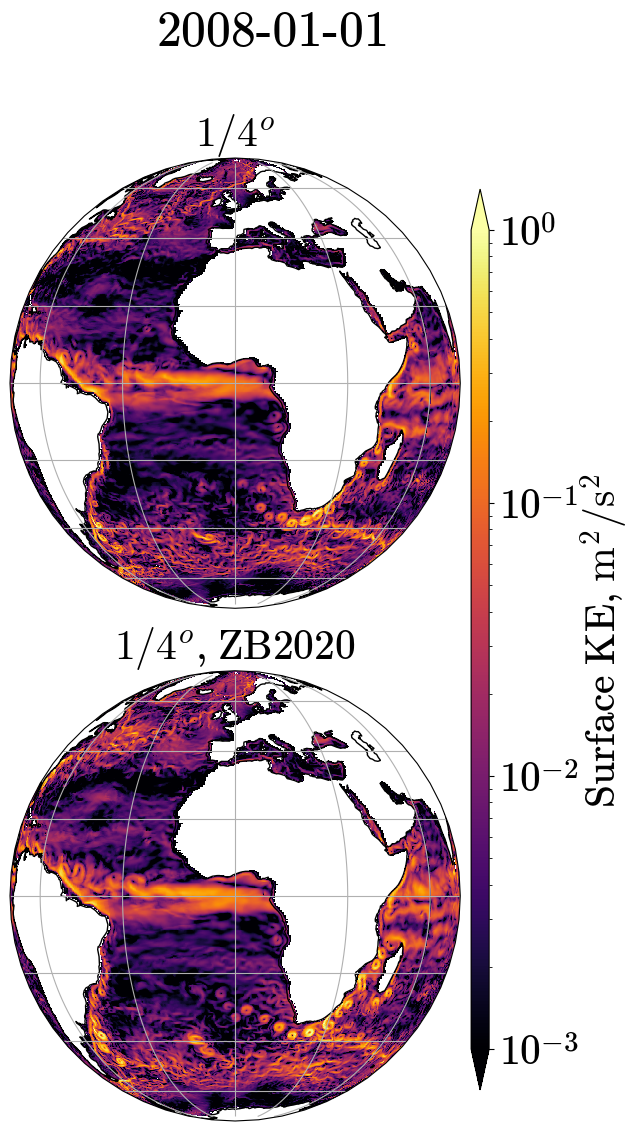

In [7]:
plot()

Here, we show the animation of the Surface Kinetic Energy in intervals of 5 days shifting the longitude by 1 degree. 


In [8]:
%%time
create_animation(
    plot, range(0, 360), "./global-ZB2020.gif", deezering=False, dpi=100, FPS=20
)

Animation at FPS=20 will last for 18.0 seconds


# Regional plotter

In [34]:
default_rcParams({"figure.subplot.hspace": 0.05, "font.size": 30})


def plot_regions(idx=0, lat=slice(15, 70), lon=slice(-100, 0)):
    fig, axes = plt.subplots(
        2,
        1,
        figsize=(7, 13),
        subplot_kw={
            "projection": ccrs.Orthographic(
                central_latitude=(lat.start + lat.stop) / 2,
                central_longitude=(lon.start + lon.stop) / 2,
            )
        },
    )

    time_idx = idx  # sampling every day
    time_str = loreske.time.isel(time=time_idx).item().strftime("%Y-%m-%d")

    ax = axes[0]
    # ax.coastlines(resolution='110m')
    ax.gridlines()
    im = (
        loreske.isel(time=time_idx)
        .sel(xh=lon, yh=lat)
        .plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0),
            cmap="inferno",
            add_colorbar=False,
        )
    )
    ax.set_title("$1/4^o$", fontsize=30)

    ax = axes[1]
    # ax.coastlines(resolution='110m')
    ax.gridlines()
    im = (
        ZBke.isel(time=time_idx)
        .sel(xh=lon, yh=lat)
        .plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0),
            cmap="inferno",
            add_colorbar=False,
        )
    )
    ax.set_title("$1/4^o$, ZB2020", fontsize=30)

    cb = plt.colorbar(im, pad=0.02, ax=axes, extend="both", aspect=50, shrink=0.9)
    cb.set_label(label="Surface KE, $\mathrm{m}^2/\mathrm{s}^2$", fontsize=30)
    plt.suptitle(time_str)

## Plotting the Surface Kinetic Energy in the North Atlantic region.

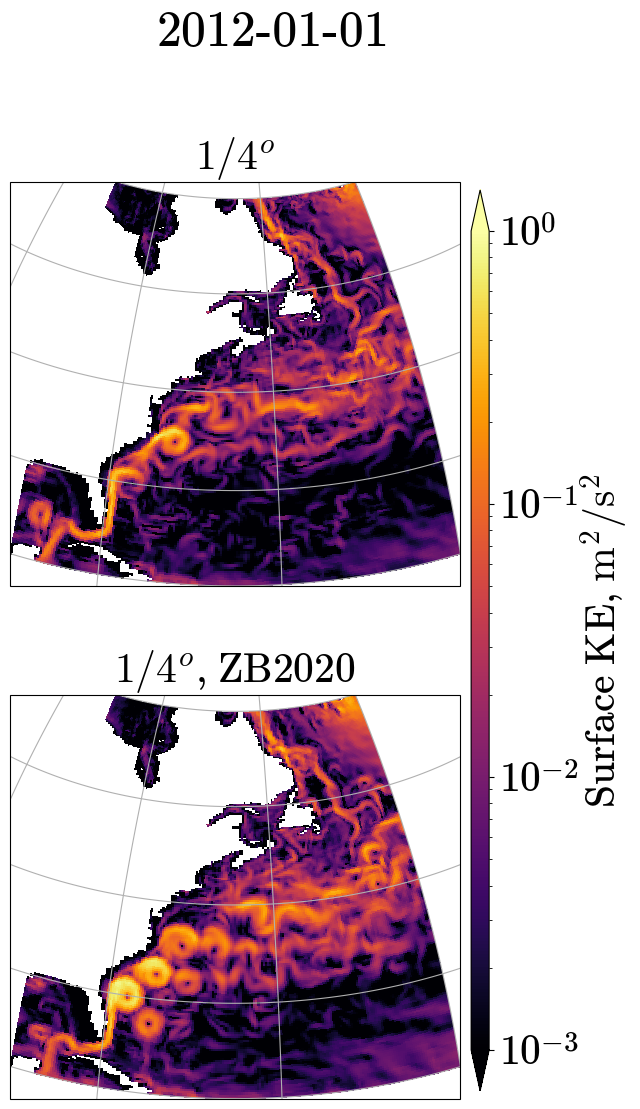

In [35]:
plot_Atlantic = lambda idx: plot_regions(
    idx=idx, lat=slice(20, 60), lon=slice(-90, -40)
)
plot_Atlantic(1461)
# plot_Atlantic(1826)

Saving the corresponding animation

In [21]:
%%time
create_animation(
    plot_Atlantic,
    range(1461, 1826, 3),
    "./global-ZB2020-Atlantic.gif",
    deezering=False,
    dpi=100,
    FPS=20,
)

Animation at FPS=20 will last for 6.1 seconds


## Plotting the Surface Kinetic Energy in the North Pacific region.

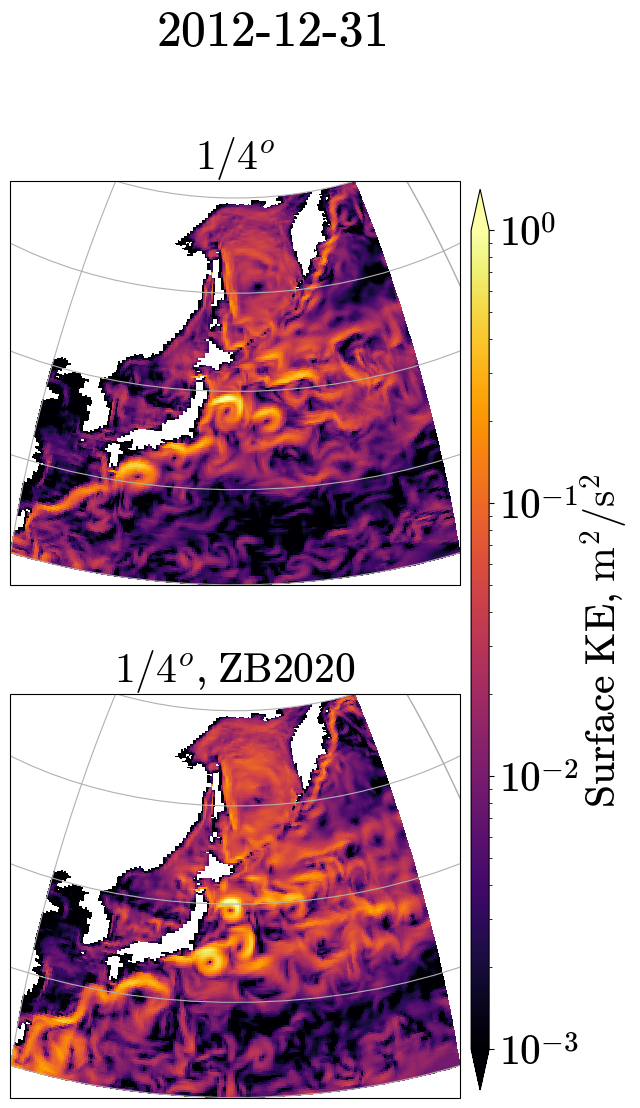

In [19]:
plot_Pacific = lambda idx: plot_regions(
    idx=idx, lat=slice(20, 60), lon=slice(-240, -190)
)
plot_Pacific(-1)

Saving the corresponding animation

In [22]:
%%time
create_animation(
    plot_Pacific,
    range(1461, 1826, 3),
    "./global-ZB2020-Pacific.gif",
    deezering=False,
    dpi=100,
    FPS=20,
)

Animation at FPS=20 will last for 6.1 seconds


## Plotting the Aghulas region

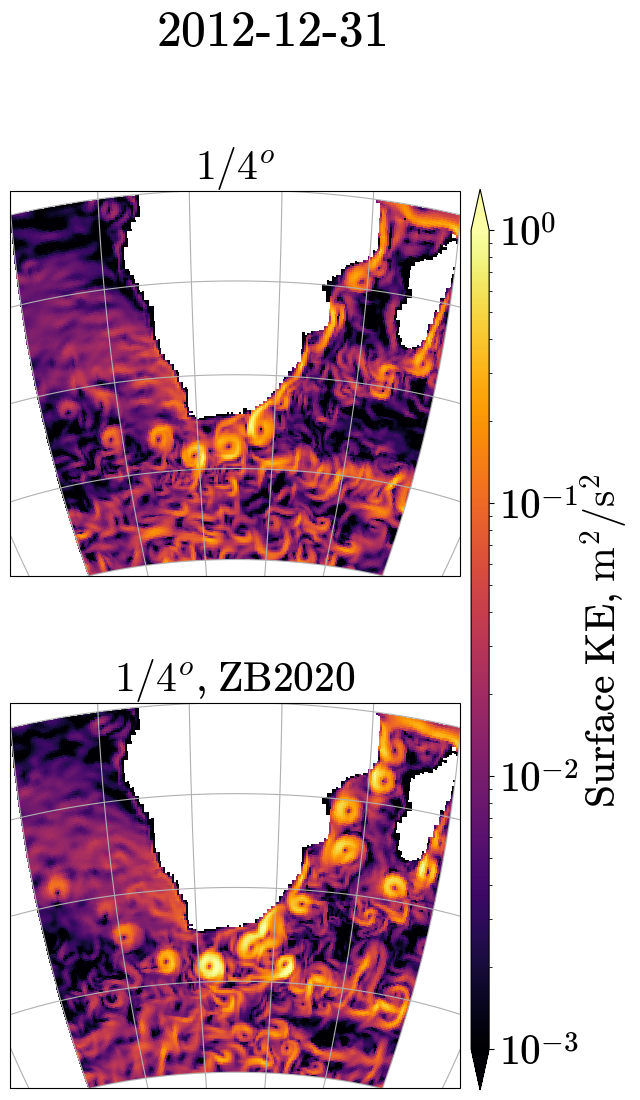

In [23]:
plot_Aghulas = lambda idx: plot_regions(idx=idx, lat=slice(-50, -10), lon=slice(0, 50))
plot_Aghulas(-1)

Saving the corresponding animation

In [24]:
%%time
create_animation(
    plot_Aghulas,
    range(1461, 1826, 3),
    "./global-ZB2020-Aghulas.gif",
    deezering=False,
    dpi=100,
    FPS=20,
)

Animation at FPS=20 will last for 6.1 seconds


# Merging gifs

In [25]:
merge_gifs(
    [
        "./global-ZB2020-Atlantic.gif",
        "./global-ZB2020-Pacific.gif",
        "./global-ZB2020-Aghulas.gif",
    ],
    "./global-ZB2020-merged.gif",
)

Merged 3 GIFs into site-visit/global-ZB2020-merged.gif
